# IBM Capstone Project: The Battle of the Neighborhoods
## Open new Indian Restaurant in Bucharest, Romania

## Introduction

In this project, I will determine which place is good for opening Indian Restaurant in Bucharest, Romania 

* I will convert address data into their equivalent latitude and longitude values. 
* For Bucharest neighborhood data, I will use wikipedia , https://en.wikipedia.org/wiki/Category:Districts of Bucharest
* I will use the Foursquare API to explore Bucharest neighborhoods and to get venues in neighborhoods. 
* I will use the Foursquare API to get venue ratings and likes in neighborhoods. 
* I will use the *k*-means clustering and Agglomerative algorithms to complete clustering task
* I will use the Folium library to visualize the neighborhoods, venues , clusters in Bucharest


## Table of Contents

1. <a href="#item1">Download and Explore Neigborhood Dataset</a>
2. <a href="#item2">Load and Analyze Venues of Neighborhoods in Bucharest</a>
3. <a href="#item3">Cluster Neighborhoods using Agglomerative Clustering</a> <br> 
4. <a href="#item4">Discussion</a>
5. <a href="#item5">Conclusion</a>    

<a id='item1'></a>
## 1. Download and Explore Neigborhood Dataset

#### Import Libraries

In [1]:
#install libraries 
!pip install geopy    
!pip install folium   
!pip install geocoder

     |████████████████████████████████| 93 kB 3.4 MB/s  eta 0:00:01
     |████████████████████████████████| 98 kB 7.2 MB/s  eta 0:00:01


In [2]:
#import libraries 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt # for graphical usage 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

# main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/
# how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k video
from bs4 import BeautifulSoup 
import pandas as pd
import requests

print('Libraries imported.')

Libraries imported.


#### Get geocoordinates of Bucharest, Romania

In [3]:
# get coordinates of Bucharest
bucharest_address = 'Bucharest, Romania'

geolocator = Nominatim(user_agent="bucharest_explorer")
location = geolocator.geocode(bucharest_address)
latitude = location.latitude
longitude = location.longitude
bucharest_center = [latitude, longitude ]
print('The geograpical coordinate of {} are {}, {}.'.format(bucharest_address, latitude, longitude))

The geograpical coordinate of Bucharest, Romania are 44.4361414, 26.1027202.


#### Get neighborhood data of Bucharest

I used wikiPedia, "Category:Districts of Bucharest" for getting neighborhoods of Bucharest . 

In [4]:
# Read Bucharest neighborhood data 
url = "https://en.wikipedia.org/wiki/Category:Districts of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

neighborhoodList = []

# append the data into the list
for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text.replace(', Bucharest',''))
    
df_neighborhood = pd.DataFrame({"Neighborhood": neighborhoodList})
print("There are {} neighborhoods in {}".format(df_neighborhood.shape[0], bucharest_address))


There are 40 neighborhoods in Bucharest, Romania


#### Get sector of neighborhood and population of sector

In [5]:
# Read Bucharest sector data from wikipedia
url = "https://en.wikipedia.org/wiki/Sectors of Bucharest"
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')

sectorPopList = []
sectorPopulationList = []

for row in soup.find_all("tbody"):
    header = str(row.findAll("th"))
    if "Population (October 2011)" in header:
        i = 0
        for td in row.find_all("td"):
            i+=1
            if i==2: 
                sectorPopList.append(td.text.replace("\n",""))
            if i==3: 
                sectorPopulationList.append(td.text.replace("\n",""))    
                i=0

df_sectorPop = pd.DataFrame({"Sector": sectorPopList, "Population": sectorPopulationList})

sectorNeigList =[]
sectorNeigborList =[]

for row in soup.find_all("ul"):
    if sectorPopList[0] in  row.text:
        for s in row.text.split("\n"):
            sectorNeigList.append(s.split(":")[0])
            sectorNeigborList.append(s.split(":")[1])
    
df_sector= pd.DataFrame({"Sector": sectorNeigList, "Neigborhoods": sectorNeigborList}).merge(df_sectorPop,on='Sector' )

print("There are {} Sector in {}".format(df_sector.shape[0], bucharest_address))
df_sector


There are 6 Sector in Bucharest, Romania


,Sector,Neigborhoods,Population
0,Sector 1,"Dorobanți, Băneasa, Aviației, Pipera, Aviator...","225,454"
1,Sector 2,"Pantelimon, Colentina, Iancului, Tei, Floreas...","345,370"
2,Sector 3,"Vitan, Dudești, Titan, Centrul Civic, Balta A...","385,439"
3,Sector 4,"Berceni, Olteniței, Văcărești, Timpuri Noi, T...","287,828"
4,Sector 5,"Rahova, Ferentari, Giurgiului, Cotroceni, 13 ...","271,575"
5,Sector 6,"Giulești, Crângași, Drumul Taberei, Militari,...","367,760"


#### Set sector of neighborhoods 

In [6]:
def getSector(row):
    for i in range(df_sector.shape[0]):
        if row["Neighborhood"] in  df_sector.iloc[i].Neigborhoods:
            return pd.Series([df_sector.iloc[i].Sector, df_sector.iloc[i].Population], index = ['Sector','SectorPopulation'])

df_neighborhood[["Sector","SectorPopulation"]] =df_neighborhood.apply(getSector, axis=1)
df_neighborhood.head(5)

,Neighborhood,Sector,SectorPopulation
0,Aviației,Sector 1,"225,454"
1,Băneasa,Sector 1,"225,454"
2,Berceni,Sector 4,"287,828"
3,Bucureștii Noi,Sector 1,"225,454"
4,Centrul Civic,Sector 3,"385,439"


#### Get geographical coordinates of neighborhoods
I use python geocoder library to get geograpical coordinates of neighborhoods

In [7]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, {}'.format(neighborhood,bucharest_address))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in df_neighborhood["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
df_neighborhood['Latitude'] = df_coords['Latitude']
df_neighborhood['Longitude'] = df_coords['Longitude']
print("Geographical coordinates of five neighborhoods are as below")
df_neighborhood.head()

Geographical coordinates of five neighborhoods are as below


,Neighborhood,Sector,SectorPopulation,Latitude,Longitude
0,Aviației,Sector 1,"225,454",44.48579,26.101220
1,Băneasa,Sector 1,"225,454",44.49401,26.080372
2,Berceni,Sector 4,"287,828",44.38620,26.128960
3,Bucureștii Noi,Sector 1,"225,454",44.48842,26.036494
4,Centrul Civic,Sector 3,"385,439",44.43430,26.094660


#### Create Bucharest map with neighborhoods superimposed
Let's see locations of neighborhoods on map. In here, I use folium library to draw map

In [8]:
#create map of Bucharest neighborhoods using latitude and longitude values
map_bucharest= folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng,  neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bucharest)  
    
map_bucharest

<a id='item2'></a>
# 2. Load Venues and Analyze Neighborhoods in Bucharest

We will use Foursquare API for getting venues of neighborhoods

#### Explore Venues of Bucharest neighborhoods
I get venue list with 1 km distance to neighborhood's center

In [38]:
# @hidden_cell


In [22]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 219 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,Aviației,44.48579,26.10122,LIDL,583956246d349d0574eb02ac,44.488396,26.094375,616,Supermarket
1,Aviației,44.48579,26.10122,ibis Styles Bucharest Erbas,5bbb782175dcb7002cc15ee7,44.483963,26.097134,382,Hotel
2,Aviației,44.48579,26.10122,Mega Image Concept Store,56348b62498e53f51a0a4e0e,44.479783,26.102568,677,Supermarket
3,Aviației,44.48579,26.10122,ORYGYNS Specialty Coffee,5807575ed67ca95d8cf5ccb9,44.480010,26.100450,646,Coffee Shop
4,Aviației,44.48579,26.10122,Starbucks,525fd077498eed1c5a52c1d6,44.478522,26.102503,815,Coffee Shop


In [23]:
print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Café,73
Restaurant,65
Coffee Shop,62
Supermarket,56
Italian Restaurant,55
Pizza Place,50
Park,41
Gym,41
Romanian Restaurant,37


#### Filter restaurants out of all venues
Let's filter venues and get only restaurants 

In [24]:
restaurant_list =['Restaurant', 'Burger Joint','Café','Fried Chicken Joint','Pizza Place']
indian_restaurant_list = ['Indian Restaurant', 'Desi Restaurant']

# Filter restaurants 
    
neighborhood_venues['RestFlag']=False
for restCat in restaurant_list:
    neighborhood_venues['RestFlag'] = neighborhood_venues['RestFlag'] | neighborhood_venues['VenueCategory'].str.contains(restCat)
    
neighborhood_restaurants = neighborhood_venues[neighborhood_venues['RestFlag'] == True].iloc[:,:-1]
indian_restaurants = neighborhood_restaurants[ neighborhood_restaurants['VenueCategory'].isin(indian_restaurant_list) ]
other_restaurants = neighborhood_restaurants[ ~neighborhood_restaurants['VenueCategory'].isin(indian_restaurant_list) ]

print('Total number of restaurants:', len(neighborhood_restaurants['VenueId'].unique()))
print('Total number of Indian restaurants:', len(indian_restaurants['VenueId'].unique()))
print('Percentage of Indian restaurants: {:.2f}%'.format(len(indian_restaurants['VenueId'].unique()) / len(neighborhood_restaurants['VenueId'].unique()) * 100))


Total number of restaurants: 501
Total number of Indian restaurants: 3
Percentage of Indian restaurants: 0.60%


34 neighborhoods do not have any Indian restaurant


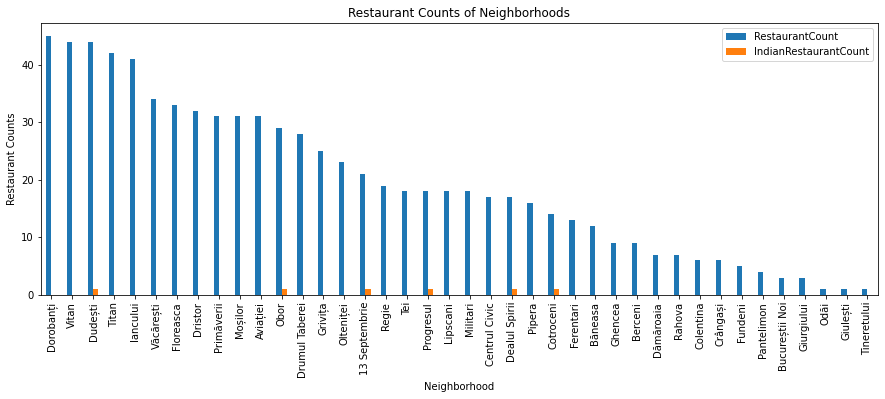

In [26]:
# get counts of restaurants in each Neighborhood
df_rest_counts =  neighborhood_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "RestaurantCount"})[['RestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_rest_counts = df_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'RestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_rest_counts.reset_index(inplace=True)

#####
# get counts of Turkish restaurants in each Neighborhood
df_ind_rest_counts =  indian_restaurants.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "IndianRestaurantCount"})[['IndianRestaurantCount']]

#find neighborhoods that does not have any restaurant 
noRestList = list(set(neighborhood_venues['Neighborhood']) - set(indian_restaurants['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noRestList != []:
    df_ind_rest_counts = df_ind_rest_counts.append (pd.DataFrame( {'Neighborhood' : noRestList  , 'IndianRestaurantCount': [0] * len(noRestList) } ).set_index('Neighborhood'))

df_ind_rest_counts.reset_index(inplace=True)
df_rest_counts= df_rest_counts.merge(df_ind_rest_counts).set_index('Neighborhood')
df_rest_counts= df_rest_counts.sort_values(by=['RestaurantCount'],ascending =False)

print('{} neighborhoods do not have any Indian restaurant'.format(len(noRestList)))
######
#Draw graph
df_rest_counts[['RestaurantCount','IndianRestaurantCount']].plot(kind='bar',figsize=(15,5))
plt.title('Restaurant Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Restaurant Counts')
plt.show()



We can see from the Graph :
* Dorobanti is the neihgborhood having most restaurants but no Indian Restaurants are there.
* Indian Restaurants are very less in number 
* Tineretului and Gluesti are neihgborhoods having least number of restaurants
* 34 neihgborhoods do not have any Turkish restaurant. we can choose one of these to open resaturant. To filter more let's continue

#### Get the restaurant's overall rating

I used Foursquare API for getting likes and rates of restaurants 

In [27]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

restaurants_raitings = getVenueRaitings(neighborhood_restaurants['VenueId'].drop_duplicates())
restaurants_raitings.head()

,VenueId,VenueRating,VenueLikes
0,58a2fc95d0bb3e516a2363b7,8.2,22.0
1,53623e44498ed583ede334f5,8.1,130.0
2,55b8a459498efbbb6ca3526d,7.9,9.0
3,58bbf8764f1069627380fed5,7.7,24.0
4,59ee47be0d8a0f244d41fca7,7.6,9.0


In [28]:
#merge raitings to restaurants 
neighborhood_restaurants = neighborhood_restaurants.merge(restaurants_raitings)
neighborhood_restaurants.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Aviației,44.48579,26.101220,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,716,Burger Joint,8.2,22.0
1,Floreasca,44.47633,26.103279,Flying Pig,58a2fc95d0bb3e516a2363b7,44.479454,26.102837,349,Burger Joint,8.2,22.0
2,Aviației,44.48579,26.101220,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,838,Restaurant,8.1,130.0
3,Floreasca,44.47633,26.103279,trickSHOT,53623e44498ed583ede334f5,44.478378,26.103135,228,Restaurant,8.1,130.0
4,Aviației,44.48579,26.101220,Toàn's,55b8a459498efbbb6ca3526d,44.478370,26.103411,844,Vietnamese Restaurant,7.9,9.0


In [29]:
#merge raitings to indian restaurants 
indian_restaurants = indian_restaurants.merge(restaurants_raitings)
indian_restaurants.head(5)

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,Cotroceni,44.430690,26.073510,TAJ,4daeed0b4df0f639f255aa92,44.422938,26.073669,863,Indian Restaurant,NaN,NaN
1,Dealul Spirii,44.422975,26.069592,TAJ,4daeed0b4df0f639f255aa92,44.422938,26.073669,324,Indian Restaurant,NaN,NaN
2,Progresul,44.423930,26.067860,TAJ,4daeed0b4df0f639f255aa92,44.422938,26.073669,474,Indian Restaurant,NaN,NaN
3,13 Septembrie,44.424995,26.083444,TAJ,4daeed0b4df0f639f255aa92,44.422938,26.073669,810,Indian Restaurant,NaN,NaN
4,Dudești,44.421013,26.132857,Ganesh,4d2b240bf7a9224b9c230da0,44.428602,26.132298,845,Indian Restaurant,NaN,NaN


#### Show restaurants on head map 

Let's crete a map showing heatmap / density of restaurants and try to extract some meaningfull info from that. Also, let's show borders of Bucharest on our map and a few circles indicating distance of 2km, 4km, 6km and 10km from Bucharest center

Red markers are Indian restaurants

Blue markers are Indian restaurants with rating less than 7 restaurants


In [30]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)
df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig, name in zip(indian_restaurants['VenueLatitude'], indian_restaurants['VenueLongitude'], indian_restaurants['Neighborhood'], indian_restaurants['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)
       
raiting_lt_7 = indian_restaurants[indian_restaurants['VenueRating'] <7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_restaurant)        
map_restaurant

From heat map , we can see that there are 
* Very less number of Indian Restaurants are there 
* Enough restaurants between 4-6 km to the center 
* There are <b> not many </b> restaurants after <b> 6 km to center </b> 
* Indian restaurants are superimposed with red and blue dots. Blue dots are Indian restaurant with raiting <7 
* <b> Indian restaurants are located in South, North , East, between 2-4 Km distance around center </b>
* There are <b> not Indian Restaurants in West Part.</b>

#### Show neighborhoods which has no Indian restaurant on head map 

Cyan markers are Neigborhoods without any indian restaurants

In [31]:
bucharest_center = [latitude, longitude]
map_restaurant= folium.Map(location=bucharest_center, zoom_start=12)

df_neighborhood_noturkrest = df_neighborhood[df_neighborhood['Neighborhood'].isin(noRestList)]

folium.TileLayer('cartodbpositron').add_to(map_bucharest) 
HeatMap(neighborhood_restaurants[['VenueLatitude','VenueLongitude']]).add_to(map_restaurant)
folium.Marker(bucharest_center).add_to(map_bucharest)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_restaurant)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_restaurant)
for lat, lon, neig in zip(df_neighborhood_noturkrest['Latitude'], df_neighborhood_noturkrest['Longitude'], df_neighborhood_noturkrest['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_restaurant)
map_restaurant

<a id='item3'></a>
# 3. Cluster Neigborhoods using Agglomerative Clustering

In [32]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

# move neighborhood column to the first column and filter only restaurant columns 
fixed_columns =['Neighborhood'] + list(neighborhood_venues['VenueCategory'].unique())
venues_grouped = venues_grouped[fixed_columns]

print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

40  neighborhoods' venue category are shown in 219 columns as below


,Neighborhood,Supermarket,Hotel,Coffee Shop,Burger Joint,Dessert Shop,Roof Deck,Beer Garden,Gym / Fitness Center,Restaurant,Grocery Store,Vietnamese Restaurant,Salad Place,Shopping Mall,Salon / Barbershop,Café,Bookstore,Sushi Restaurant,Steakhouse,Pie Shop,Italian Restaurant,Clothing Store,Turkish Restaurant,Toy / Game Store,Bakery,Sandwich Place,Lebanese Restaurant,Casino,Spanish Restaurant,Pizza Place,Middle Eastern Restaurant,Event Space,Indoor Play Area,Eastern European Restaurant,Fried Chicken Joint,Lounge,Gym,Stadium,Mongolian Restaurant,Tennis Stadium,Cosmetics Shop,Cocktail Bar,Donut Shop,Bus Station,Romanian Restaurant,Doner Restaurant,Vegetarian / Vegan Restaurant,Lake,Park,Nightclub,Tunnel,Theme Restaurant,Farmers Market,Soccer Field,Nature Preserve,Fast Food Restaurant,Food & Drink Shop,Electronics Store,Fountain,Gas Station,Theater,Cupcake Shop,Pharmacy,Mexican Restaurant,Light Rail Station,Mobile Phone Shop,Department Store,Shop & Service,Korean Restaurant,Gastropub,Outdoor Sculpture,Bistro,Indie Theater,Monastery,Skating Rink,Ice Cream Shop,Used Bookstore,Chocolate Shop,Tea Room,Plaza,Art Museum,Beer Bar,Historic Site,Bar,Wine Bar,Concert Hall,Rock Club,Boutique,Swiss Restaurant,Hostel,Art Gallery,Tattoo Parlor,Hardware Store,Discount Store,Arts & Crafts Store,Auto Dealership,Furniture / Home Store,Gift Shop,Tennis Court,French Restaurant,Jazz Club,Accessories Store,Market,Opera House,Spa,Pedestrian Plaza,Hotel Bar,Indian Restaurant,Music Store,Pub,Pool,Garden,Indie Movie Theater,Australian Restaurant,Shoe Store,Climbing Gym,Drugstore,IT Services,Soccer Stadium,Miscellaneous Shop,Convenience Store,Outlet Mall,Women's Store,Intersection,Flower Shop,Japanese Restaurant,Fish Market,Scandinavian Restaurant,Juice Bar,Asian Restaurant,Cheese Shop,Mediterranean Restaurant,Modern European Restaurant,Seafood Restaurant,Fruit & Vegetable Store,German Restaurant,Wine Shop,Molecular Gastronomy Restaurant,Hookah Bar,American Restaurant,Auto Workshop,Pet Store,Multiplex,Eye Doctor,Chinese Restaurant,Skate Park,Greek Restaurant,Metro Station,Water Park,Brewery,Ballroom,Tram Station,Bed & Breakfast,Sports Club,Health Food Store,Diner,Jewelry Store,Sporting Goods Shop,Portuguese Restaurant,Science Museum,Lingerie Store,Boxing Gym,Athletics & Sports,Bagel Shop,Museum,Health & Beauty Service,History Museum,Food Truck,Buffet,Movie Theater,Kebab Restaurant,Exhibit,Snack Place,Public Art,Factory,Pool Hall,Gourmet Shop,Palace,Falafel Restaurant,Cultural Center,Football Stadium,Construction & Landscaping,BBQ Joint,Big Box Store,Hungarian Restaurant,Karaoke Bar,RV Park,Beach,Auto Garage,Go Kart Track,Food Court,Track,Gym Pool,Recreation Center,Bike Shop,Creperie,Bike Rental / Bike Share,Boat or Ferry,Veterinarian,Dog Run,Basketball Court,Paper / Office Supplies Store,Bowling Alley,Sports Bar,Laundromat,Lighting Store,Kids Store,Comfort Food Restaurant,Taco Place,Fish & Chips Shop,Racetrack,Playground,Recording Studio,Soup Place,Circus,Dance Studio,Pet Café,Leather Goods Store,Gaming Cafe,Camera Store
0,13 Septembrie,1,2,1,0,1,0,0,2,5,2,0,0,0,0,4,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,2,1,0,0,0,0,1,0,1,2,0,0,0,1,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,2,4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,1,1,0,3,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,1,0,0,0,0,0,0,0
1,Aviației,4,4,4,3,2,1,1,2,6,1,1,1,1,1,6,1,2,3,1,1,2,1,1,5,1,2,1,1,4,1,1,2,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Berceni,0,0,0,0,0,0,1,2,1,2,0,0,0,0,1,0,0,0,0,0,0

In [33]:
# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

,Neighborhood,Total Number of Venues,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,13 Septembrie,72,Restaurant,Café,Plaza,Pub,Comfort Food Restaurant,Gym / Fitness Center,Hotel,Lounge,Seafood Restaurant,Romanian Restaurant
1,Aviației,79,Restaurant,Café,Bakery,Supermarket,Pizza Place,Hotel,Coffee Shop,Burger Joint,Steakhouse,Dessert Shop
2,Berceni,22,Pizza Place,Grocery Store,Gym / Fitness Center,Nature Preserve,Lebanese Restaurant,Park,Gym,Café,Farmers Market,Bakery
3,Bucureștii Noi,22,Supermarket,Gym,Park,Grocery Store,Shop & Service,Theater,Cupcake Shop,Soccer Field,Farmers Market,Pharmacy
4,Băneasa,24,Restaurant,Romanian Restaurant,Hotel,Italian Restaurant,Theme Restaurant,Park,Nightclub,Tunnel,Sandwich Place,Farmers Market


#### Cluster and find similarities between neighborhoods

I will use hierarchical agglomerative clustering method to compare neighborhoods among neighborhoods

First, find the number of clusters. Let's use scipy library to create the dendrograms for our dataset

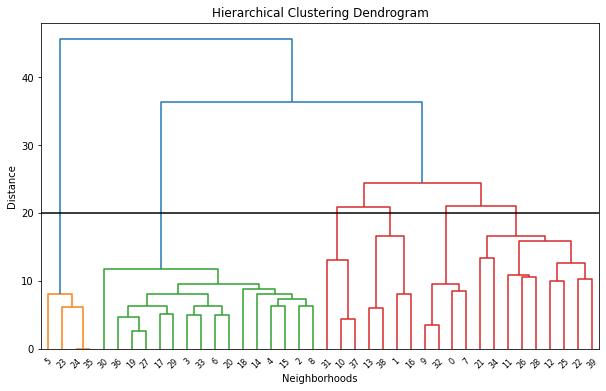

In [34]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

According to the above graph, I decide to separate our neighborhoods into 6 clusters (cut at distance of 20, horizontal black line). 
I will use the hierarchical agglomerative clustering of the sklearn.cluster library to cluster these neighborhoods.

In [35]:
from sklearn.cluster import AgglomerativeClustering

kclusters= 6
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['NeighborhoodCluster'] = clusterresult
venues_cluster= df_neighborhood.merge(venues_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighborhood','1st Most Common Restaurant','2nd Most Common Restaurant','3rd Most Common Restaurant']])
venues_cluster.head()


,Neighborhood,Sector,SectorPopulation,Latitude,Longitude,NeighborhoodCluster,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant
0,Aviației,Sector 1,"225,454",44.48579,26.101220,1,Restaurant,Café,Bakery
1,Băneasa,Sector 1,"225,454",44.49401,26.080372,5,Restaurant,Romanian Restaurant,Hotel
2,Berceni,Sector 4,"287,828",44.38620,26.128960,5,Pizza Place,Grocery Store,Gym / Fitness Center
3,Bucureștii Noi,Sector 1,"225,454",44.48842,26.036494,5,Supermarket,Gym,Park
4,Centrul Civic,Sector 3,"385,439",44.43430,26.094660,3,Coffee Shop,Hotel,Theater


In [36]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster, sector,SectorPopulation  in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster'], venues_cluster['Sector'],venues_cluster['SectorPopulation']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)+ ' ' + str(sector) + ' ' + str(SectorPopulation), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(bucharest_center).add_to(map_clusters)
folium.Circle(bucharest_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(bucharest_center, radius=10000, fill=False, color='black').add_to(map_clusters)         
map_clusters

In [37]:
print(venues_cluster.groupby(['NeighborhoodCluster','1st Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['NeighborhoodCluster','2nd Most Common Restaurant' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

                                                 Neighborhood Count
NeighborhoodCluster 1st Most Common Restaurant                     
0                   Coffee Shop                                   1
                    Italian Restaurant                            3
                    Park                                          1
                    Pizza Place                                   2
                    Pub                                           1
                    Supermarket                                   1
1                   Café                                          2
                    Coffee Shop                                   1
                    Restaurant                                    1
2                   Café                                          2
                    Coffee Shop                                   1
3                   Coffee Shop                                   4
4                   Hotel                       

Neighborhood Count
NeighborhoodCluster 2nd Most Common Restaurant                    
0                   Café                                         1
                    Clothing Store                               1
                    Italian Restaurant                           2
                    Pizza Place                                  2
                    Pub                                          1
                    Supermarket                                  2
1                   Bakery                                       1
                    Café                                         1
                    Restaurant                                   1
                    Supermarket                                  1
2                   Coffee Shop                                  2
                    Lounge                                       1
3                   Hotel                                        4
4                   Café                                         1
                    Plaza                                        1
                    Supermarket                                  2
5                   Arts & Crafts Store                          1
                    Auto Garage                                  1
                    Burger Joint                                 1
                    Grocery Store                                1
                    Gym                                          2
                    Gym / Fitness Center                         1
                    Hardware Store                               1
                    Metro Station                                1
                    Pedestrian Plaza                             1
                    Pub                                          1
                    Restaurant                                   1
                    Romanian Restaurant                          1
                    Soccer Field                                 1
                    Supermarket                                  2

#### We can see cluster categories as below  <br>
Cluster 0 (Red)     : Italian Restaurant , Pizza, Café  <br>
Cluster 1 (Purple)  : Restaurant , Bar <br>
Cluster 2 (BLue)    : Park , Plaza, Clothing stores  <br>
Cluster 3 (Cyan)    : Coffee Shop, Hotel, Pub <br>
Cluster 4 (Green)   : Café, Suprmarket <br>
Cluster 5 (Orange)  : Café <br>

<a id='item4'></a>
## 4. Discussion 

Cluster 2 suffers from restaurant. Especially there is no Indian restaurant in west part inluding Cluster 2 . We can think about Cluster 2 , West part

Cluster 0 especially likes Itallian tastes , may be this part will not like Indian tastes . We can only think about 1 location may be .

Cluster 1, 2, 3 are centers full of restaurants as we saw in the heatmap also


<a id='item5'></a>
## 5. Conclusion

Possible Neighborhoods to set up a Indian restaurant :


•	Neighborhood : Regie ,  Cluster 0, Sector 6 , Population : 367760      

    I choosed Regie , since west part of Bucharest has not Indian restaurant and Regie is close to center . Regie is red cluster which is same with the other 2 red markers having Indian restaurant. Red clusters populations may like Indian food. 

•	Neighborhood : Bucureștii Noi ,  Cluster 2,  Sector 1 , Population : 225453

    I choosed Bucharest-noi , since west part of Bucharest has not Indian restaurant and even not too much restaurant after 6 km distance to center . One restaurant will be good for this area.

•	Neighborhood : Crângași ,  Cluster 2,  Sector 6 , Population : 367760

    I choosed Crangasi , since Crangasi  and west part of Bucharest has not Indian restaurant and from bar chart we can see that this neighborhood has not too much restaurant. Also this neighborhood is in Sector 6 and this sector has biggest population which will handle one more restaurant 

•	Neighborhood : Tineretului ,  Cluster 2,  Sector 4 , Population : 287828

    I choosed Tineretului , since Tineretului has not Indian restaurant and from bar chart we can see that this neighborhood has not too much restaurant. 



        